In [1]:
#Various Python modules for basic needs.
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

#Core Libra routines for model potentials, data types, etc.
from liblibra_core import *
import util.libutil as comn
import libra_py.data_savers as data_savers

#QTAG modules implemented in Libra.
import libra_py.dynamics.qtag.compute as compute
import libra_py.dynamics.qtag.initialize as initialize
import libra_py.dynamics.qtag.plot as plot
import libra_py.dynamics.qtag.save as save

/projects/academic/cyberwksp21/SOFTWARE/Conda/envs/libra2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/SOFTWARE/Conda/envs/libra2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/SOFTWARE/Conda/envs/libra2/lib/python3.7/importlib/_bootstrap.py:219: Runtime

In [2]:
class tmp:
    pass

In [3]:
def SAC_mimic(q, params, full_id):
    critical_params = [ ]
    default_params = {"A":0.010, "B":1.600, "C":0.005, "D":1.000}
    comn.check_input(params, default_params, critical_params)

    A = params["A"]
    B = params["B"]
    C = params["C"]
    D = params["D"]

    Id = Cpp2Py(full_id)
    indx = Id[-1]
    x = q.col(indx).get(0)
    
    Hdia = CMATRIX(2,2)
    Sdia = CMATRIX(2,2)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(2,2) )
    d2ham_dia = CMATRIXList();  d2ham_dia.append( CMATRIX(2,2) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(2,2) )

    Sdia.set(0,0, 1.0+0.0j);  Sdia.set(0,1, 0.0+0.0j);
    Sdia.set(1,0, 0.0+0.0j);  Sdia.set(1,1, 1.0+0.0j);

    V11, dV11, d2V11 = 0.0, 0.0, 0.0
    V22, dV22, d2V22 = 0.0, 0.0, 0.0
    V12, dV12, d2V12 = 0.0, 0.0, 0.0
    
    th = np.tanh(B*x)
    e = np.exp(-D*x*x)
    
    V11 = A*(1.0+th)
    V22 = A*(1.0-th)
    V12 = C*e

    dV11 = A*B*(1-th*th)
    dV22 = -A*B*(1.0-th*th)
    dV12 = -2.0*x*C*D*e
    
    d2V11 = -2.0*A*B*B*th*(1.0-th*th)
    d2V22 = 2.0*A*B*B*th*(1.0-th*th)
    d2V12 = 4.0*C*D*e*(D*x*x-0.5)

    Hdia.set(0,0, V11*(1.0+0.0j));  Hdia.set(0,1, V12*(1.0+0.0j));
    Hdia.set(1,0, V12*(1.0+0.0j));  Hdia.set(1,1, V22*(1.0+0.0j));

    for i in [0]:
        d1ham_dia[i].set(0,0, dV11*(1.0+0.0j));  d1ham_dia[i].set(0,1, dV12*(1.0+0.0j));
        d1ham_dia[i].set(1,0, dV12*(1.0+0.0j));  d1ham_dia[i].set(1,1, dV22*(1.0+0.0j));

        d2ham_dia[i].set(0,0, d2V11*(1.0+0.0j));  d2ham_dia[i].set(0,1, d2V12*(1.0+0.0j));
        d2ham_dia[i].set(1,0, d2V12*(1.0+0.0j));  d2ham_dia[i].set(1,1, d2V22*(1.0+0.0j));
        
        #  <dia| d/dR_0| dia >
        dc1_dia[i].set(0,0, 0.0+0.0j);  dc1_dia[i].set(0,1, 0.0+0.0j);
        dc1_dia[i].set(1,0, 0.0+0.0j);  dc1_dia[i].set(1,1, 0.0+0.0j);

    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.d2ham_dia = d2ham_dia
    obj.dc1_dia = dc1_dia

    return obj

In [4]:
def DAC_mimic(q, params, full_id):
    critical_params = [ ]
    default_params = {"A":0.1, "B":0.028, "C":0.015, "D":0.06, "E":0.05}
    comn.check_input(params, default_params, critical_params)

    A = params["A"]
    B = params["B"]
    C = params["C"]
    D = params["D"]
    E = params["E"]

    Id = Cpp2Py(full_id)
    indx = Id[-1]
    x = q.get(0,indx)
    
    Hdia = CMATRIX(2,2)
    Sdia = CMATRIX(2,2)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(2,2) )
    d2ham_dia = CMATRIXList();  d2ham_dia.append( CMATRIX(2,2) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(2,2) )

    Sdia.set(0,0, 1.0+0.0j);  Sdia.set(0,1, 0.0+0.0j);
    Sdia.set(1,0, 0.0+0.0j);  Sdia.set(1,1, 1.0+0.0j);

    V11, dV11, d2V11 = 0.0, 0.0, 0.0
    V22, dV22, d2V22 = 0.0, 0.0, 0.0
    V12, dV12, d2V12 = 0.0, 0.0, 0.0
    
    b22 = np.exp(-B*x*x)
    e = np.exp(-D*x*x)
    
    V11 = 0.0
    V22 = -A*b22+E
    V12 = C*e
    
    dV11 = 0.0
    dV22 = 2.0*A*B*x*b22
    dV12 = -2.0*x*C*D*e
    
    d2V11 = 0.0
    d2V22 = 2.0*A*B*b22*(1.0-2.0*B*x*x)
    d2V12 = 4.0*C*D*e*(D*x*x-0.5)

    Hdia.set(0,0, V11*(1.0+0.0j));  Hdia.set(0,1, V12*(1.0+0.0j));
    Hdia.set(1,0, V12*(1.0+0.0j));  Hdia.set(1,1, V22*(1.0+0.0j));

    for i in [0]:
        d1ham_dia[i].set(0,0, dV11*(1.0+0.0j));  d1ham_dia[i].set(0,1, dV12*(1.0+0.0j));
        d1ham_dia[i].set(1,0, dV12*(1.0+0.0j));  d1ham_dia[i].set(1,1, dV22*(1.0+0.0j));

        d2ham_dia[i].set(0,0, d2V11*(1.0+0.0j));  d2ham_dia[i].set(0,1, d2V12*(1.0+0.0j));
        d2ham_dia[i].set(1,0, d2V12*(1.0+0.0j));  d2ham_dia[i].set(1,1, d2V22*(1.0+0.0j));
        
        #  <dia| d/dR_0| dia >
        dc1_dia[i].set(0,0, 0.0+0.0j);  dc1_dia[i].set(0,1, 0.0+0.0j);
        dc1_dia[i].set(1,0, 0.0+0.0j);  dc1_dia[i].set(1,1, 0.0+0.0j);

    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.d2ham_dia = d2ham_dia
    obj.dc1_dia = dc1_dia

    return obj

In [5]:
def compute_model(q, model_params, full_id):

    model = model_params["model"]
    res = None
    
    if model==0:
        res = SAC_mimic(q, model_params, full_id)
    elif model==1:
        res = DAC_mimic(q, model_params, full_id)
    else:
        print("Unrecognized model! Check for correct model import statement.")

    return res

In [6]:
#Potential parameters for SAC
model_params = {
    "model":0,
    "deriv_lvl":2, #1 for BAT, 2 for LHA
    "A":0.01,
    "B":1.147,
    "C":0.005,
    "D":1.0,
    "ex_cpl_A":0.005,
    "ex_cpl_B":1.0,
    "ex_cpl_C":0.0
}

#Potential parameters for DAC
#model_params = {
#    "model":1,
#    "deriv_lvl":1, #1 for BAT, 2 for LHA
#    "A":0.1,
#    "B":0.28,
#    "C":0.015,
#    "D":0.06,
#    "E":0.05,
#    "ex_cpl_A":0.015,
#    "ex_cpl_B":0.06,
#    "ex_cpl_C":0.0
#}

In [7]:
#Parameters for general simulation, SAC
if model_params["model"]==0:
    dyn_params = {
    "init_placement":0,
    "wfc_q0":[-5.0], "wfc_p0":[10.0], "wfc_a0":[2.0], "wfc_s0":[0.0],
    "states":[0, 1], "grid_dims":[35], "alp_scl":[15.0], "rho_cut":1e-12   
    }

#Parameters for general simulation, DAC
elif model_params["model"]==1:
    dyn_params = {
    "init_placement":0,
    "wfc_q0":[-5.0], "wfc_p0":[10.0], "wfc_a0":[2.0], "wfc_s0":[0.0],
    "states":[0, 1], "grid_dims":[35], "alp_scl":[25.0], "rho_cut":1e-12
    }

else:
    print("Unrecognized model! Check for correct model import statement.")

ntraj, Q, P, A, S, active_states = initialize.initialize(dyn_params)

In [8]:
Q0 = MATRIX(1,1); Q0.set(0,0, dyn_params['wfc_q0'][0])
P0 = MATRIX(1,1); P0.set(0,0, dyn_params['wfc_p0'][0])
A0 = MATRIX(1,1); A0.set(0,0, dyn_params['wfc_a0'][0])
S0 = MATRIX(1,1); S0.set(0,0, dyn_params['wfc_s0'][0])
istate = [0]

C = initialize.coeffs(Q0, P0, A0, S0, istate, Q, P, A, S, active_states)

In [9]:
# 1D mass, SAC and DAC
iM = MATRIX(1, 1);  iM.set(0,0,0.0005);

#Parameters for general simulation, SAC and DAC
dyn_params = {
    "target_states":[0,1], "states":[0,1],
    "dt":1, "nsteps":2000, "iM":iM,
    "hdf5_output_level":0, "txt2_output_level":3, 
    "properties_to_save":["time","Etot","pops","q","p","a","coeffs"],
    "q_update_method":1, "p_update_method":1, "a_update_method":1, "s_update_method":0,  
    "q_sync_method":1, "p_sync_method":0, "a_sync_method":0, "s_sync_method":0,
    "mom_calc_type":1, "linfit_beta":1e-3, "d_weight":1.0, "qtag_pot_approx_method":3
}

#SAC-specific dynamic parameters
if model_params["model"]==0:
    dyn_params.update({ "decpl_den":0.1, "prefix":"SAC"})

#DAC-specific dynamic parameters
elif model_params["model"]==1:
    dyn_params.update({ "decpl_den":0.01, "prefix":"DAC"})

else:
    print("Unrecognized model! Check for correct model import statement.")

compute.run_qtag(Q, P, A, S, active_states, C, iM, dyn_params, compute_model, model_params)

0.0255002664587642 [0.9999999999950999, 1.732174382373824e-20]
0.02550026645891371 [1.0000000000009581, 1.6118347640966462e-19]
0.025500266459175754 [1.0000000000109912, 4.629322058081529e-19]
0.025500266459260106 [1.0000000000144333, 9.381790895311437e-19]
0.025500266459095613 [1.0000000000076354, 1.6036087970180615e-18]
0.025500266459184583 [1.0000000000108509, 2.4770533023583683e-18]
0.0255002664590564 [1.0000000000057179, 3.577550933073057e-18]
0.025500266459081763 [1.00000000000678, 4.925428683928713e-18]
0.02550026645907281 [1.0000000000063023, 6.542375798410969e-18]
0.02550026645904694 [1.000000000004915, 8.451526862396779e-18]
0.02550026645911865 [1.0000000000072617, 1.0677547947854886e-17]
0.025500266459084386 [1.0000000000053006, 1.3246726374818981e-17]
0.025500266459182328 [1.000000000008938, 1.6187076645544e-17]
0.025500266458943672 [0.9999999999991618, 1.9528447652096594e-17]
0.025500266458871983 [0.9999999999957646, 2.3302615892682977e-17]
0.025500266458952967 [0.99999999

(<liblibra_core.MATRIX at 0x2aef9b189e30>,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 <liblibra_core.CMATRIX at 0x2aef9b1762d0>)

Number of files = 5


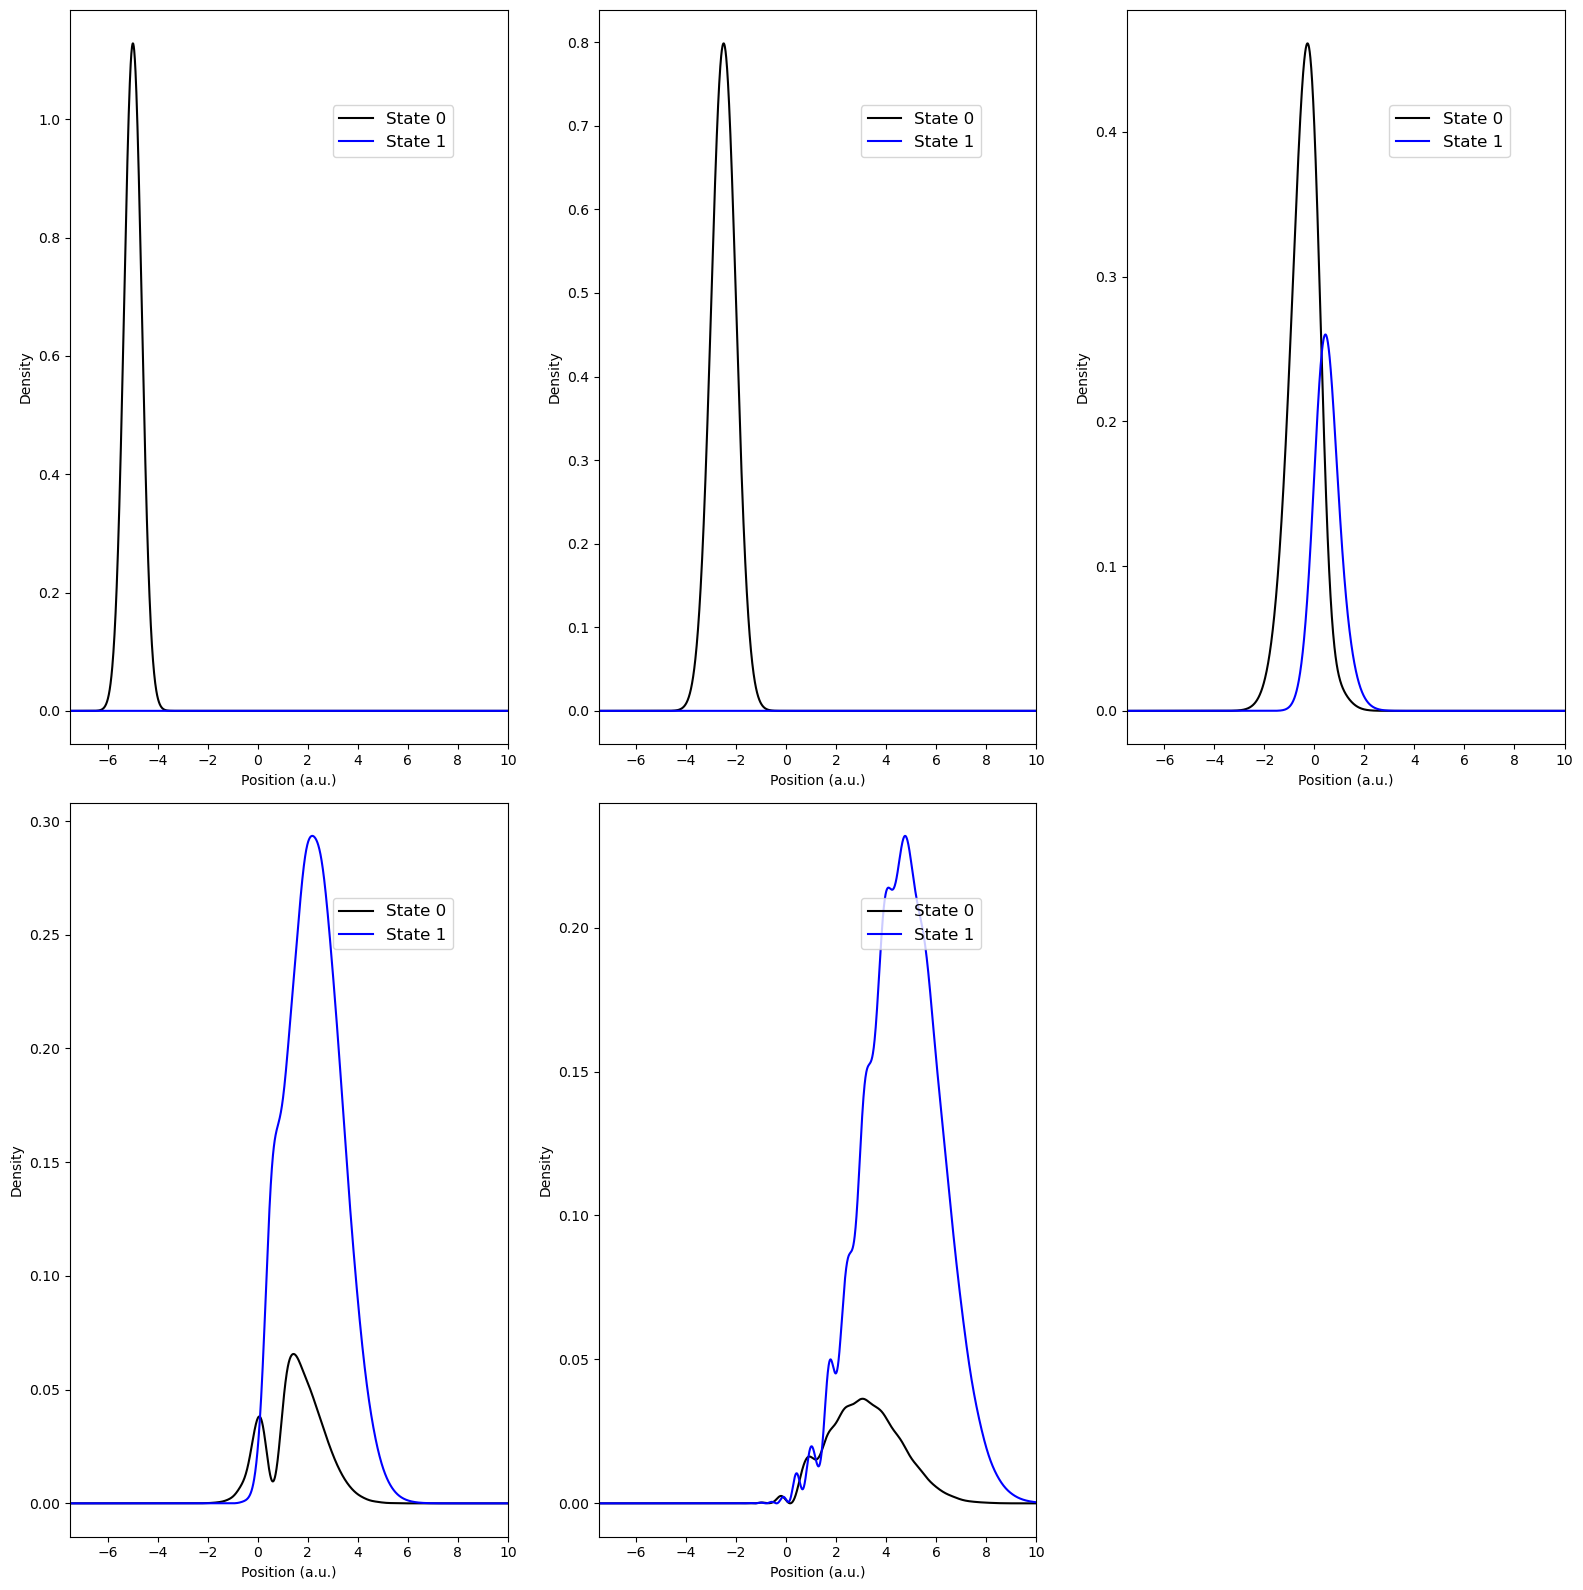

In [11]:
#Plot parameters dictionary definitions for wavefunction output...
dyn_params.update( { "ndof":1, "grid_dims":[35] })
plt_params = {'prefix':dyn_params['prefix'], 'which_states':[0,1], 
              'size':(16,16), 'xmin':[-7.5],'xmax':[10.0],
              'npoints':[2000], 'snaps':[0,499,999,1499,1999],
              'xlabel':'Position (a.u.)', 'ylabel':'Density', 'zlabel':'N/A',
              '1Dcolors':['Black','Blue'], '2Dcolors':['Reds','Blues'],
              'legend_loc':(0.6,0.8), 'legend_size':12,
              "grid_dims":dyn_params['grid_dims']
             }

#Call wf_calc_nD to calculate gridded wavefunction data from coefficients and qpas output...
compute.wf_calc_nD(dyn_params, plt_params, plt_params['prefix'])

#Plot the selected snapshots...
plot.wf_plot(dyn_params, plt_params)

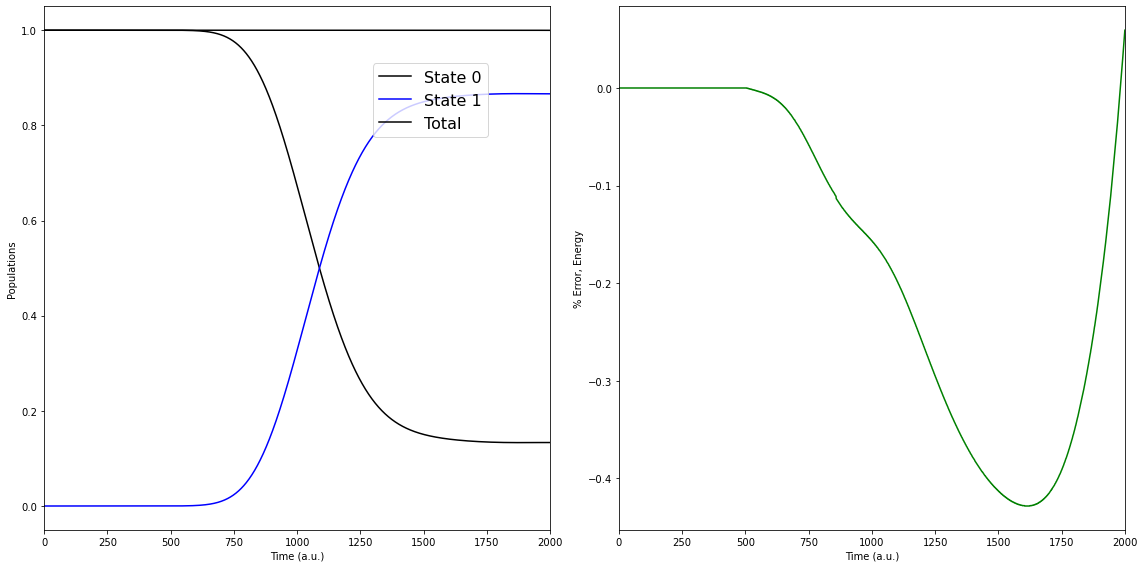

In [12]:
#Plot parameters dictionary definitions for energy/population output...
plt_params = {'prefix':dyn_params['prefix'], 'size':(16,8), 'xmin':[0], 'xmax':[2000.0], 
              '1Dcolors':['Black','Blue'], 'legend_loc':(0.65,0.75), 'legend_size':16}

#Plot the graphs...
plot.energy_and_pops(dyn_params, plt_params)

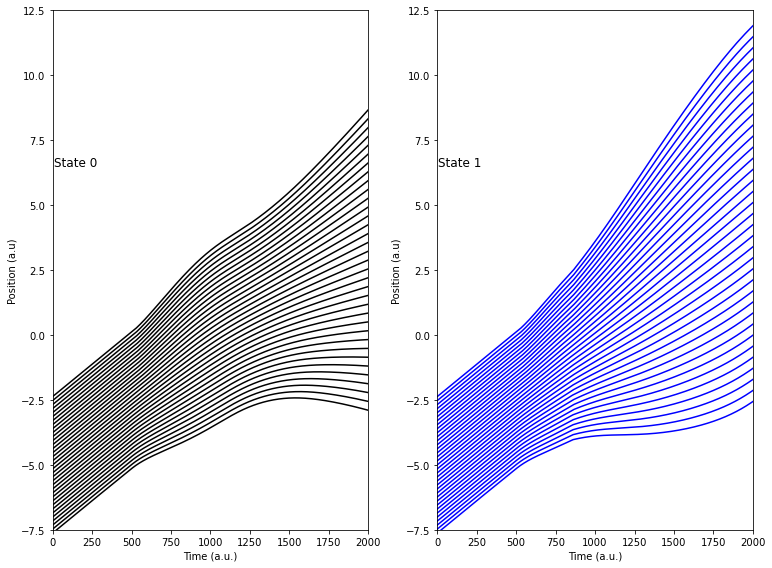

In [13]:
#Plot parameters dictionary definitions for trajectory output...
plt_params = {'prefix':dyn_params['prefix'], 'which_states':[0, 1], 'which_traj':'all', 
              'size':(16,8), 'xlabel':'Time (a.u.)', 'ylabel':'Position (a.u)', 'zlabel':'N/A',
              '1Dcolors':['Black','Blue']}

if model_params["model"]==0:
    plt_params.update({'xmin':[0,-7.5],'xmax':[2000.0,12.5]})
elif model_params["model"]==1:
    plt_params.update({'xmin':[0,-7.5],'xmax':[2000.0,30.0]})
else:
    print("Unrecognized model! Check for correct model import statement.")
    
#Plot the output...
plot.trajectories(dyn_params, plt_params)